<a href="https://colab.research.google.com/github/avocardio/Project/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import shutil
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing import image
%matplotlib inline

from sklearn.decomposition import PCA
from math import ceil

## Load data
The dataset is already splitted into train and validation data and reduced to 10 classes with 100 images per class.

In [2]:
DIR_TRAIN = '../Data/Use/Train/'
DIR_VALID = '../Data/Use/Valid/'

## Data Exploration

The ideas of data exploration are based on this blogpost:
https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

Before starting with training our classification models, we want to explore our dataset to get a basic understanding of the classes and images we deal with. We aim to grasp the structure of our data better to identify necessary preprocessing steps as well as guiding our modelling process.

### Raw Images
Show random samples of the bird classes.

In [3]:
def print_length_dictionary(dct, which_set):
    """
    Prints the size of items in a dictionary in a nice way
    
    Parameters:
    ----------
    dct : dict
        dictionary
    which_set : str
        train val or test
    """
    print('Number of images per {} class:'.format(which_set))
    for item, value in dct.items():
        print("{} : {}".format(item, value))

The bird classes are: 
CASPIAN TERN
D-ARNAUDS BARBET
DARK EYED JUNCO
HOUSE FINCH
OVENBIRD
OYSTER CATCHER
RED TAILED HAWK
SWINHOES PHEASANT
VIOLET GREEN SWALLOW
WOOD DUCK

Number of images per train class:
CASPIAN TERN : 100
D-ARNAUDS BARBET : 100
DARK EYED JUNCO : 100
HOUSE FINCH : 100
OVENBIRD : 100
OYSTER CATCHER : 100
RED TAILED HAWK : 100
SWINHOES PHEASANT : 100
VIOLET GREEN SWALLOW : 100
WOOD DUCK : 100


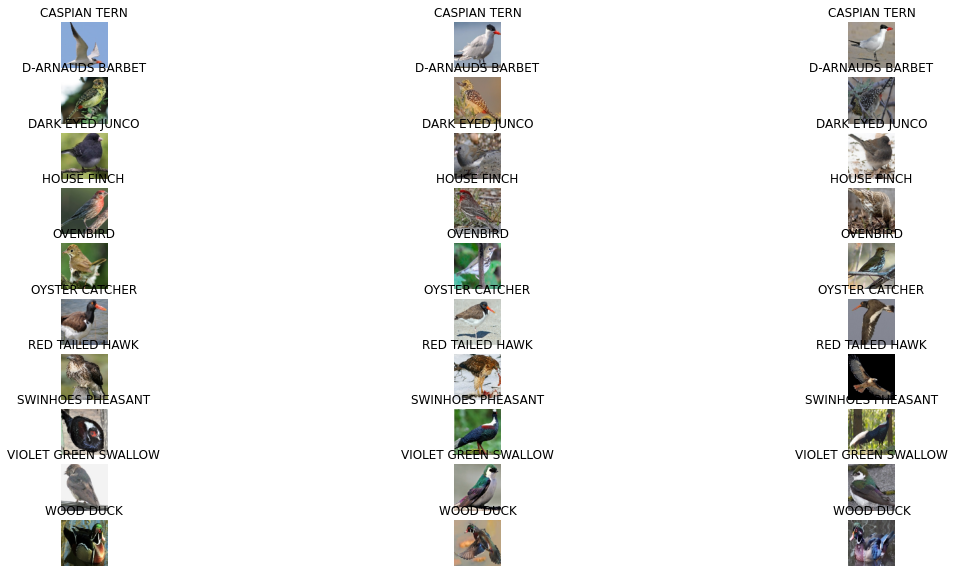

In [9]:
# use the training data for data exploration
data_dir_train = DIR_TRAIN

# store the bird names in a list
bird_names = [name for name in os.listdir(data_dir_train)]

# dictionaries for storing the images belonging to each bird class and randomly selected for plotting
bird_dic = {}
select_dic = {}

print('The bird classes are: ')

# for each bird class do
for name in bird_names:
  print(name)

  # get the list of jpgs
  bird_dic[name] = [fn for fn in os.listdir('{}/{}'.format(data_dir_train, name)) if fn.endswith('jpg')]

  # randomly select 3 images
  select_dic[name] = np.random.choice(bird_dic[name], 3, replace = False)

# number of images per training class
lengths_dic = {key:len(value) for key,value in iter(bird_dic.items())}
print()
print_length_dictionary(lengths_dic, 'train')

# plotting 10 x 3 image matrix
fig = plt.figure(figsize = (20,10))
for i in range(30):
    if i < 3:
        fp = '{}/CASPIAN TERN/{}'.format(data_dir_train, select_dic['CASPIAN TERN'][i])
        label = 'CASPIAN TERN'
    elif i >= 3 and i < 6:
        fp = '{}/D-ARNAUDS BARBET/{}'.format(data_dir_train, select_dic['D-ARNAUDS BARBET'][i-3])
        label = 'D-ARNAUDS BARBET'
    elif i >= 6 and i < 9:
        fp = '{}/DARK EYED JUNCO/{}'.format(data_dir_train, select_dic['DARK EYED JUNCO'][i-6])
        label = 'DARK EYED JUNCO'
    elif i >= 9 and i < 12:
        fp = '{}/HOUSE FINCH/{}'.format(data_dir_train, select_dic['HOUSE FINCH'][i-9])
        label = 'HOUSE FINCH'
    elif i >= 12 and i < 15:
        fp = '{}/OVENBIRD/{}'.format(data_dir_train, select_dic['OVENBIRD'][i-12])
        label = 'OVENBIRD'
    elif i >= 15 and i < 18:
        fp = '{}/OYSTER CATCHER/{}'.format(data_dir_train, select_dic['OYSTER CATCHER'][i-15])
        label = 'OYSTER CATCHER'
    elif i >= 18 and i < 21:
        fp = '{}/RED TAILED HAWK/{}'.format(data_dir_train, select_dic['RED TAILED HAWK'][i-18])
        label = 'RED TAILED HAWK'
    elif i >= 21 and i < 24:
        fp = '{}/SWINHOES PHEASANT/{}'.format(data_dir_train, select_dic['SWINHOES PHEASANT'][i-21])
        label = 'SWINHOES PHEASANT'
    elif i >= 24 and i < 27:
        fp = '{}/VIOLET GREEN SWALLOW/{}'.format(data_dir_train, select_dic['VIOLET GREEN SWALLOW'][i-24])
        label = 'VIOLET GREEN SWALLOW'
    else:
        fp = '{}/WOOD DUCK/{}'.format(data_dir_train, select_dic['WOOD DUCK'][i-27])
        label = 'WOOD DUCK'
    ax = fig.add_subplot(10, 3, i+1)
    
    fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')
    plt.imshow(fn)
    plt.title(label)
    plt.axis('off')
plt.show()

### Images as Matrix
Convert the images into matrices of pixel values. The matrices will have the size (number of images per class x number of pixels).

In [27]:
def img2np(path, list_of_filename, size = (64, 64)):
    """
    Converts images to a nxm matrix.
    
    Parameters:
    ----------
    path : str
        filepath of image
    list_of_filename : list
        lists the endings of the files per class
    size : tuple
        specifies the numbers of pixels used for each image  
        
    Returns:
    -------
    full_mat : np.array
        matrix of size (number of images per class x number of pixels)
    """
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

pixel_dic = {}

# run on the bird folders
for name in bird_names:
  pixel_dic[name] = img2np('{}/{}/'.format(data_dir_train, name), bird_dic[name])

### Average Image per class
Show the average image per class by taking the average value of each pixel across all images per class.

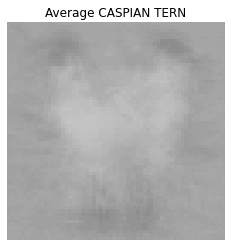

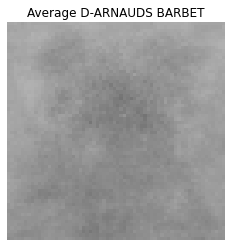

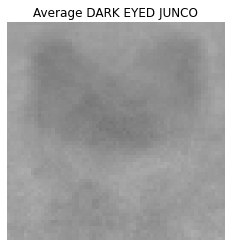

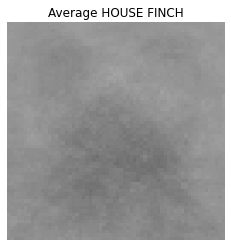

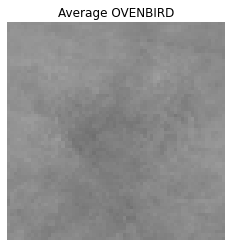

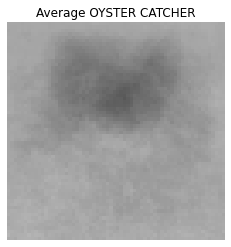

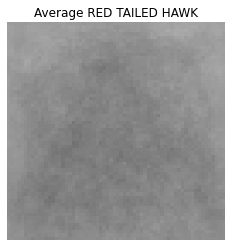

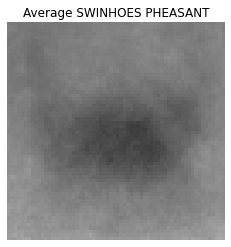

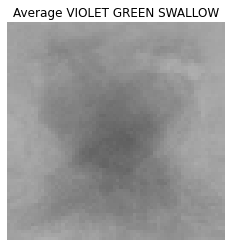

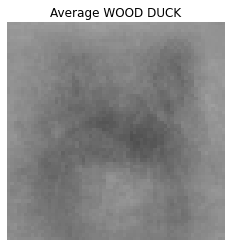

CASPIAN TERN
D-ARNAUDS BARBET
DARK EYED JUNCO
HOUSE FINCH
OVENBIRD
OYSTER CATCHER
RED TAILED HAWK
SWINHOES PHEASANT
VIOLET GREEN SWALLOW
WOOD DUCK


In [36]:
def find_mean_img(full_mat, title, size = (64, 64)):
    """
    Finds the mean image per class.
    
    Parameters:
    ----------
    full_mat : np.array
        pixel matrix of a bird class
    title : str
        title of the bird class
    size : tuple
        number of pixels for an image
        
    Returns:
    -------
    mean_img : np.array
        the mean image
    """
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

mean_dic = {}

for name in bird_names:
  mean_dic[name] = find_mean_img(pixel_dic[name], name)

In [46]:
import cv2

def save_mean_img(mean_dict):
    """
    Creates a folder and saves the average image of each class.
    
    Parameters:
    ----------
    mean_dict : dic
        dictionary with the mean image for all classes
    """
    os.mkdir('../Data/Use/Average')
    
    for idx,mean_img in enumerate(mean_dic):
        os.mkdir('../Data/Use/Average/{}'.format(mean_img))
        img_to_save = mean_dic[mean_img]
        cv2.imwrite('../Data/Use/Average/{}/{}.jpg'.format(mean_img, idx), img_to_save)

# !!!Execute this code snippet only once!!!
save_mean_img(mean_dic)

### Eigenimages

Uses PCA to visualize the components that describe 70% of each class best. The number of selected principal components vary for each class according to the structure in the images.

CASPIAN TERN
Number of PC:  14


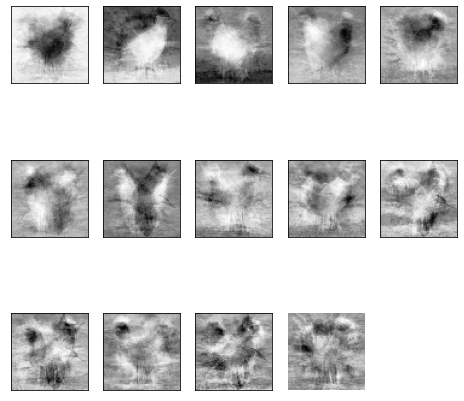

D-ARNAUDS BARBET
Number of PC:  27


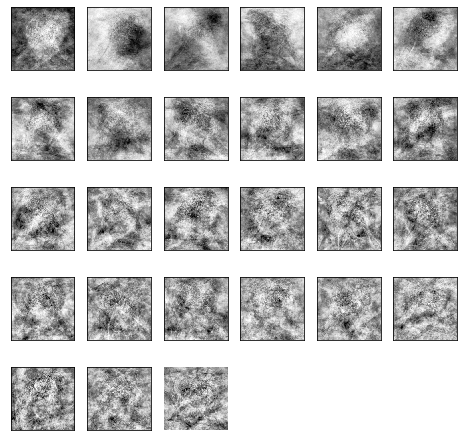

DARK EYED JUNCO
Number of PC:  16


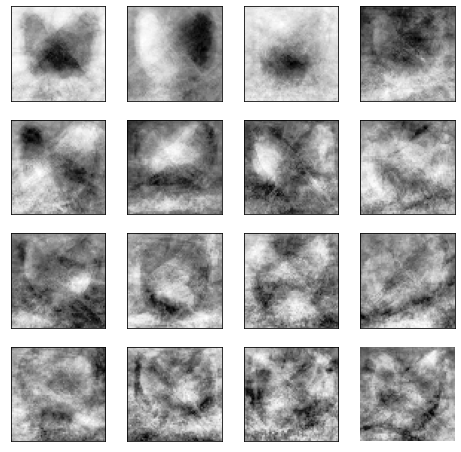

HOUSE FINCH
Number of PC:  18


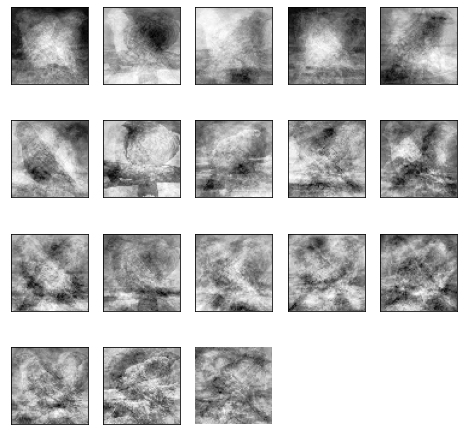

OVENBIRD
Number of PC:  27


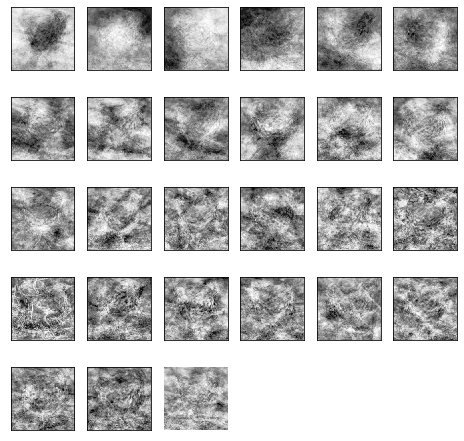

OYSTER CATCHER
Number of PC:  18


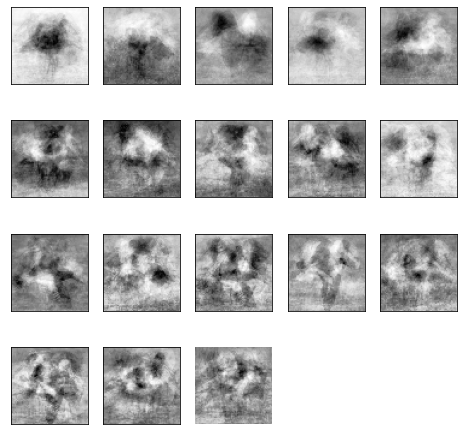

RED TAILED HAWK
Number of PC:  20


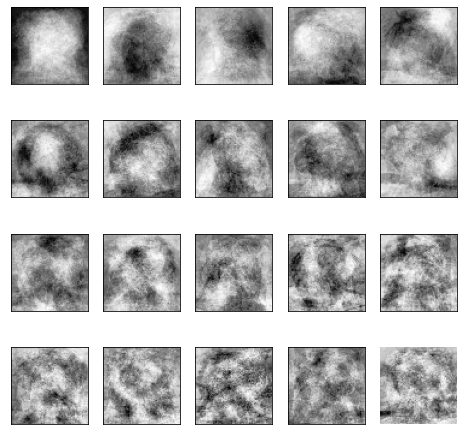

SWINHOES PHEASANT
Number of PC:  24


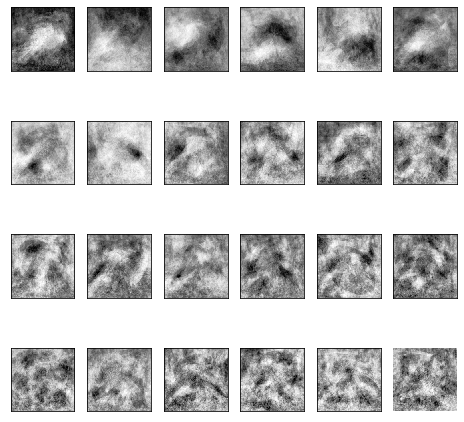

VIOLET GREEN SWALLOW
Number of PC:  18


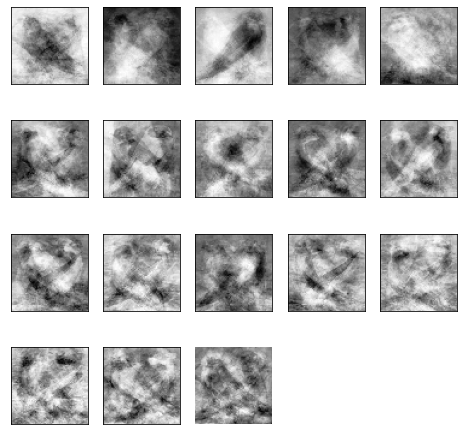

WOOD DUCK
Number of PC:  29


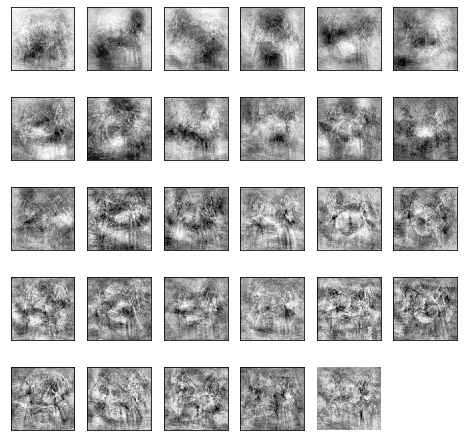

In [31]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    """
    Fits PCA to describe n_comp * variability in the class.
    
    Parameters:
    ----------
    full_mat : np.array
        pixel array of image
    title : str
        bird name
    n_comp : float
        amount of variability that should be displayed
    size : tuple
        pixel size of images
        
    Returns:
    -------
    pca : sklearn.decomposition._pca.PCA
        principal component analysis
    """
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print(title)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    """
    Plots the eigenimages in a grid.
    
    Parameters:
    ----------
    pca : sklearn.decomposition._pca.PCA
        principal component analysis
    size : tuple
        pixel size of the images
    """
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
for name in bird_names:
  plot_pca(eigenimages(pixel_dic[name], name))